Tujuan dari tugas ini adalah untuk melakukan forecasting (peramalan) konsumsi energi per jam menggunakan model deep learning berbasis LSTM (Long Short-Term Memory) . Dataset yang digunakan berasal dari Kaggle: Hourly Energy Consumption .

---
LSTM cocok untuk data time series karena mampu menangkap pola sekuensial.
kami akan membandingkan tiga jenis model:
LSTM biasa
Bidirectional LSTM (Bi-LSTM)
Stacked LSTM

---
 Metrik Evaluasi:
MSE (Mean Squared Error)
RMSE (Root Mean Squared Error)
MAE (Mean Absolute Error)



In [1]:
# install library kaggle
!pip install -q kaggle

In [2]:
# upload kaggle.json yang sudah di download
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"erliandikasyahputra","key":"7e93cec898e651ea8cc41bc870e51bc4"}'}

In [3]:
# make directory and change permission
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
# download dataset
!kaggle datasets download -d robikscube/hourly-energy-consumption

Dataset URL: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
License(s): CC0-1.0
  0% 0.00/11.4M [00:00<?, ?B/s]
100% 11.4M/11.4M [00:00<00:00, 550MB/s]


In [5]:
# ekstrak dataset
!unzip -o hourly-energy-consumption.zip -d /content/hourly-energy-consumption

Archive:  hourly-energy-consumption.zip
  inflating: /content/hourly-energy-consumption/AEP_hourly.csv  
  inflating: /content/hourly-energy-consumption/COMED_hourly.csv  
  inflating: /content/hourly-energy-consumption/DAYTON_hourly.csv  
  inflating: /content/hourly-energy-consumption/DEOK_hourly.csv  
  inflating: /content/hourly-energy-consumption/DOM_hourly.csv  
  inflating: /content/hourly-energy-consumption/DUQ_hourly.csv  
  inflating: /content/hourly-energy-consumption/EKPC_hourly.csv  
  inflating: /content/hourly-energy-consumption/FE_hourly.csv  
  inflating: /content/hourly-energy-consumption/NI_hourly.csv  
  inflating: /content/hourly-energy-consumption/PJME_hourly.csv  
  inflating: /content/hourly-energy-consumption/PJMW_hourly.csv  
  inflating: /content/hourly-energy-consumption/PJM_Load_hourly.csv  
  inflating: /content/hourly-energy-consumption/est_hourly.paruqet  
  inflating: /content/hourly-energy-consumption/pjm_hourly_est.csv  


In [6]:
# import dataset
import pandas as pd
df = pd.read_csv('/content/hourly-energy-consumption/AEP_hourly.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [8]:
print(df.columns)


Index(['Datetime', 'AEP_MW'], dtype='object')


In [9]:
df_subset = df.head(3000)

In [10]:
# Cek missing values
print(df_subset.isnull().sum())

# Kalau ada NA
df_subset = df_subset.dropna()

# Optional: Ganti nama kolom
df_subset.rename(columns={'AEP_MW': 'energy_consumption'}, inplace=True)



Datetime    0
AEP_MW      0
dtype: int64


File CSV energy_3000_rows.csv di-load ke dalam DataFrame menggunakan Pandas.
Kolom Datetime dijadikan sebagai index agar sesuai dengan sifat time series.
Data diurutkan berdasarkan waktu (sort_index) untuk memastikan urutan benar.
Hanya kolom energy_consumption yang dipakai untuk prediksi.

In [11]:
data = df.drop_duplicates()
data.duplicated().sum()

np.int64(0)

In [12]:
df_subset.to_csv('energy_3000_rows.csv', index=False)
print("✅ Dataset siap digunakan dan disimpan sebagai 'energy_3000_rows.csv'")


✅ Dataset siap digunakan dan disimpan sebagai 'energy_3000_rows.csv'


In [19]:
import pandas as pd
import numpy as np

# Load dataset yang sudah kamu potong 3000 baris
df = pd.read_csv('energy_3000_rows.csv', parse_dates=['Datetime'])

# Pastikan datetime jadi index
df.set_index('Datetime', inplace=True)
df = df.sort_index()

# Fokus pada kolom konsumsi saja
data = df[['energy_consumption']]



In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


Normalisasi data dilakukan agar semua nilai berada dalam rentang [0, 1], membantu proses pelatihan model LSTM.
Digunakan MinMaxScaler() dari scikit-learn.
Proses ini penting karena LSTM sangat sensitif terhadap skala input.

In [21]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24  # gunakan 24 jam terakhir untuk prediksi jam berikutnya
X, y = create_sequences(data_scaled, seq_length)


Fungsi create_sequences() mengubah data time series menjadi format supervised learning.
Setiap input (X) berisi 24 jam sebelumnya, dan output (y) adalah jam berikutnya.
Contoh: Gunakan konsumsi listrik dari jam 0–23 untuk memprediksi jam 24.

In [22]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape ke bentuk (samples, timesteps, features) untuk LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


Data dibagi menjadi 80% train dan 20% test .
Dimensi data disesuaikan agar cocok dengan input layer model LSTM: [samples, timesteps, features].
Format ini diperlukan oleh model LSTM untuk dapat memproses data secara temporal.


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
history = model_lstm.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.1343 - val_loss: 0.0174
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0151 - val_loss: 0.0129
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0132 - val_loss: 0.0115
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0090 - val_loss: 0.0070
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0064 - val_loss: 0.0043
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0049 - val_loss: 0.0058
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0

Membangun model LSTM sederhana dengan 50 neuron.
Layer Dense(1) memberikan output berupa satu nilai prediksi (konsumsi listrik jam berikutnya).
Model dilatih selama 20 epoch dengan optimisasi Adam dan fungsi loss MSE.

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Prediksi
y_pred = model_lstm.predict(X_test)

# Kembalikan ke bentuk aslinya
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Evaluasi
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print(f'MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}')


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
MSE: 151513.29, RMSE: 389.25, MAE: 283.25


In [37]:
from tensorflow.keras.layers import Bidirectional

# Buat model Bi-LSTM
model_bilstm = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(seq_length, 1)),
    Dense(1)
])
model_bilstm.compile(optimizer='adam', loss='mse')

# Latih model
history_bilstm = model_bilstm.fit(X_train, y_train,
                                  epochs=20,
                                  validation_data=(X_test, y_test),
                                  verbose=1)
# Prediksi
y_pred_bilstm = model_bilstm.predict(X_test)

# Inverse transform
y_pred_bilstm_inv = scaler.inverse_transform(y_pred_bilstm)
y_test_inv = scaler.inverse_transform(y_test)

# Evaluasi
mse_bilstm = mean_squared_error(y_test_inv, y_pred_bilstm_inv)
rmse_bilstm = math.sqrt(mse_bilstm)
mae_bilstm = mean_absolute_error(y_test_inv, y_pred_bilstm_inv)

print(f'Bi-LSTM - MSE: {mse_bilstm:.2f}, RMSE: {rmse_bilstm:.2f}, MAE: {mae_bilstm:.2f}')

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0771 - val_loss: 0.0105
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0094 - val_loss: 0.0078
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0066 - val_loss: 0.0052
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0034 - val_loss: 0.0055
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0014 - val_l

In [38]:
from tensorflow.keras.layers import Bidirectional

# Buat model Bi-LSTM
model_bilstm = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(seq_length, 1)),
    Dense(1)
])
model_bilstm.compile(optimizer='adam', loss='mse')

# Latih model
history_bilstm = model_bilstm.fit(X_train, y_train,
                                  epochs=20,
                                  validation_data=(X_test, y_test),
                                  verbose=1)
# Prediksi
y_pred_bilstm = model_bilstm.predict(X_test)

# Inverse transform
y_pred_bilstm_inv = scaler.inverse_transform(y_pred_bilstm)
y_test_inv = scaler.inverse_transform(y_test)

# Evaluasi
mse_bilstm = mean_squared_error(y_test_inv, y_pred_bilstm_inv)
rmse_bilstm = math.sqrt(mse_bilstm)
mae_bilstm = mean_absolute_error(y_test_inv, y_pred_bilstm_inv)

# Correct the typo in the print statement from maei_bilstm to mae_bilstm
print(f'Bi-LSTM - MSE: {mse_bilstm:.2f}, RMSE: {rmse_bilstm:.2f}, MAE: {mae_bilstm:.2f}')

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0712 - val_loss: 0.0112
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0096 - val_loss: 0.0089
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0069 - val_loss: 0.0052
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0030 - val_loss: 0.0060
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0010 - val_loss: 8.8634e-04
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0010 - v

In [39]:
# Buat model Stacked LSTM
model_stacked = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
model_stacked.compile(optimizer='adam', loss='mse')

# Latih model
history_stacked = model_stacked.fit(X_train, y_train,
                                    epochs=20,
                                    validation_data=(X_test, y_test),
                                    verbose=1)

# Prediksi
y_pred_stacked = model_stacked.predict(X_test)

# Inverse transform
y_pred_stacked_inv = scaler.inverse_transform(y_pred_stacked)

# Evaluasi
mse_stacked = mean_squared_error(y_test_inv, y_pred_stacked_inv)
rmse_stacked = math.sqrt(mse_stacked)
mae_stacked = mean_absolute_error(y_test_inv, y_pred_stacked_inv)

print(f'Stacked LSTM - MSE: {mse_stacked:.2f}, RMSE: {rmse_stacked:.2f}, MAE: {mae_stacked:.2f}')

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0942 - val_loss: 0.0144
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0157 - val_loss: 0.0140
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0133 - val_loss: 0.0103
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0091 - val_loss: 0.0066
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0046 - val_loss: 0.0058
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0020 - val_loss: 0.0060
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0019 - val_l

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


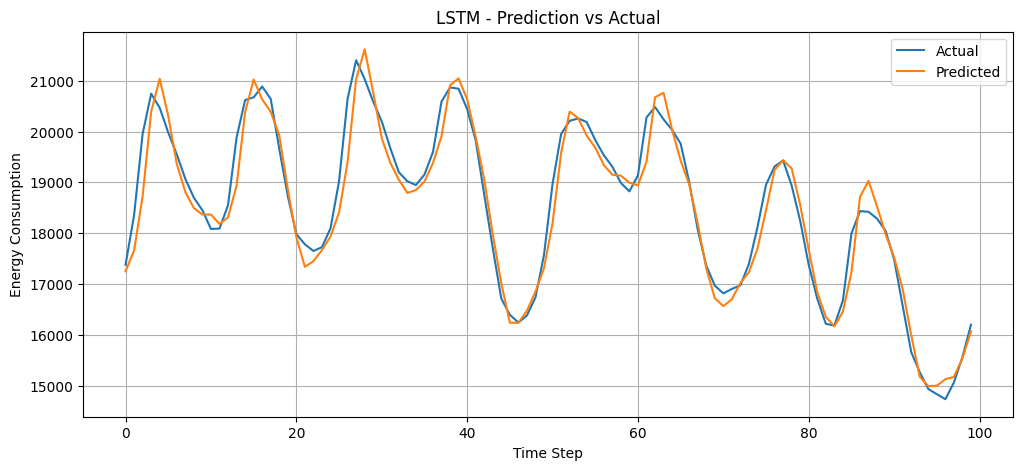

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


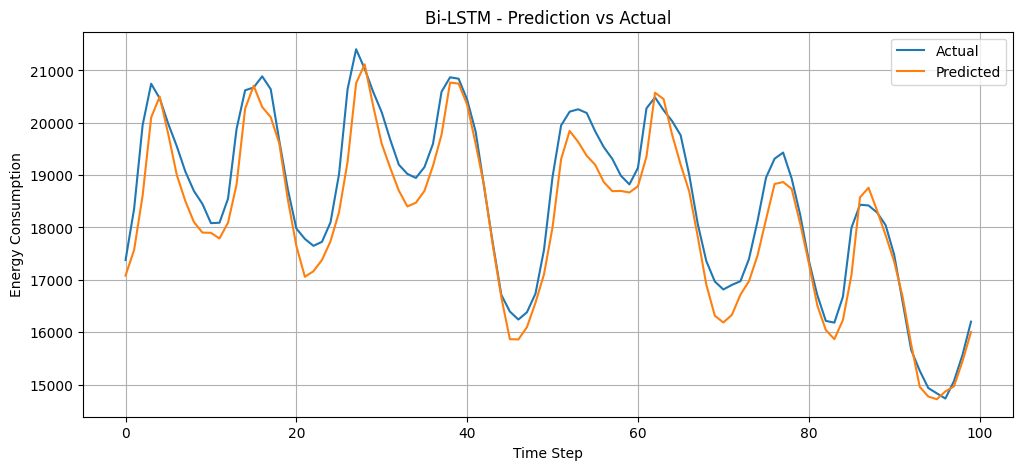

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


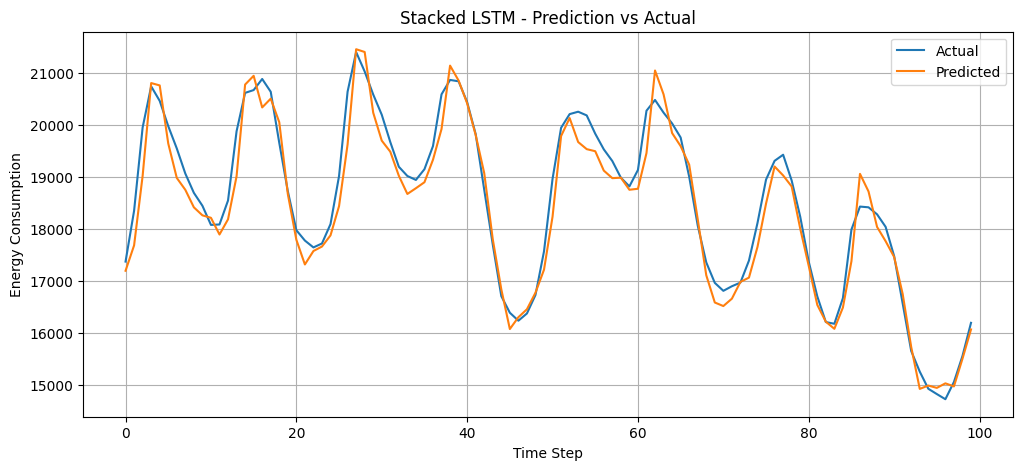

In [40]:
import matplotlib.pyplot as plt

# Fungsi untuk plot prediksi vs aktual
def plot_prediction(model, X_test, y_test, scaler, title):
    # Prediksi
    y_pred = model.predict(X_test)

    # Kembalikan ke skala asli
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_inv[:100], label='Actual')
    plt.plot(y_pred_inv[:100], label='Predicted')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot hasil prediksi untuk masing-masing model
plot_prediction(model_lstm, X_test, y_test, scaler, "LSTM - Prediction vs Actual")
plot_prediction(model_bilstm, X_test, y_test, scaler, "Bi-LSTM - Prediction vs Actual")
plot_prediction(model_stacked, X_test, y_test, scaler, "Stacked LSTM - Prediction vs Actual")

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

def evaluate_model(model, X_test, y_test, scaler, model_name):
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)

    print(f"{model_name}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print("----------------------------")

# Evaluasi tiap model
evaluate_model(model_lstm, X_test, y_test, scaler, "LSTM")
evaluate_model(model_bilstm, X_test, y_test, scaler, "Bi-LSTM")
evaluate_model(model_stacked, X_test, y_test, scaler, "Stacked LSTM")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LSTM
MSE: 151513.29
RMSE: 389.25
MAE: 283.25
----------------------------
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Bi-LSTM
MSE: 246711.95
RMSE: 496.70
MAE: 397.12
----------------------------
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Stacked LSTM
MSE: 147620.76
RMSE: 384.21
MAE: 300.19
----------------------------


In [42]:
# Tampilkan dalam bentuk tabel
import pandas as pd

results = pd.DataFrame({
    'Model': ['LSTM', 'Bi-LSTM', 'Stacked LSTM'],
    'MSE': [mse, mse_bilstm, mse_stacked],
    'RMSE': [rmse, rmse_bilstm, rmse_stacked],
    'MAE': [mae, mae_bilstm, mae_stacked]
})

print(results.to_string(index=False))

       Model           MSE       RMSE        MAE
        LSTM 151513.294618 389.247087 283.253108
     Bi-LSTM 246711.950582 496.701068 397.123217
Stacked LSTM 147620.758867 384.214470 300.190210


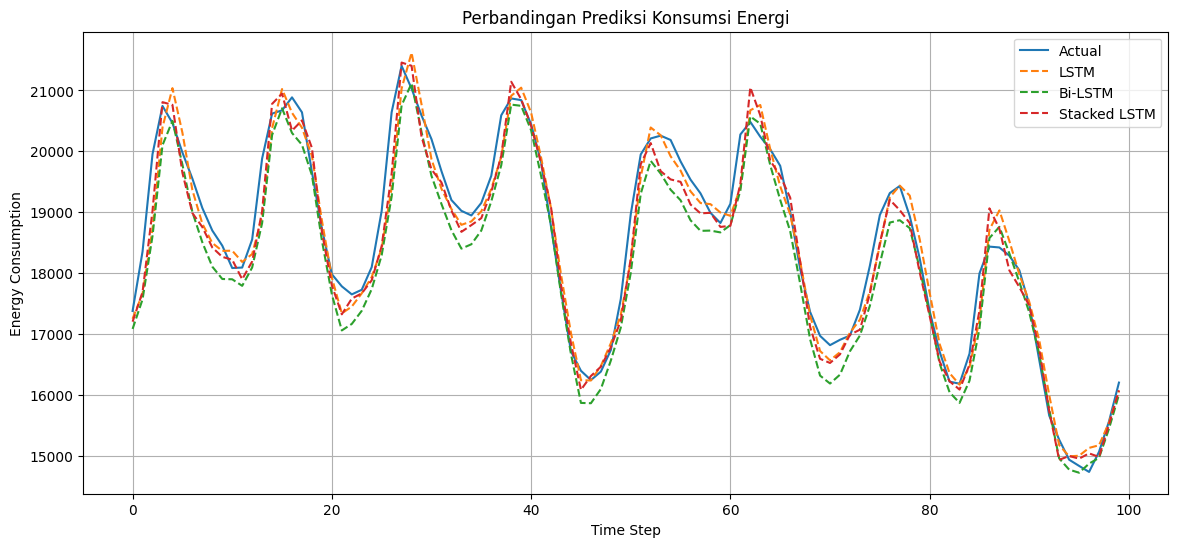

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_test_inv[:100], label='Actual')
plt.plot(y_pred_inv[:100], label='LSTM', linestyle='--')
plt.plot(y_pred_bilstm_inv[:100], label='Bi-LSTM', linestyle='--')
plt.plot(y_pred_stacked_inv[:100], label='Stacked LSTM', linestyle='--')

plt.title('Perbandingan Prediksi Konsumsi Energi')
plt.xlabel('Time Step')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

📊 Perbandingan Ketiga Model:
       Model           MSE       RMSE        MAE
        LSTM 151513.294618 389.247087 283.253108
     Bi-LSTM 246711.950582 496.701068 397.123217
Stacked LSTM 147620.758867 384.214470 300.190210

📈 Visualisasi Prediksi vs Aktual:


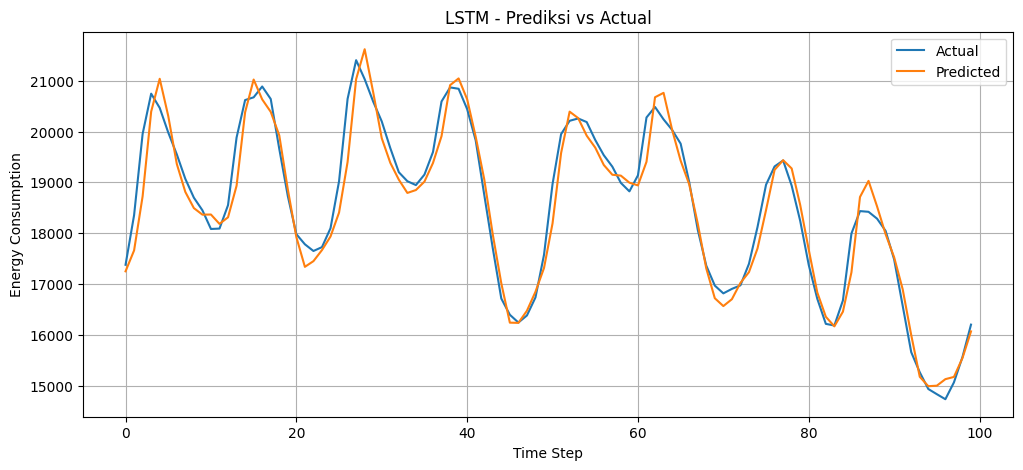

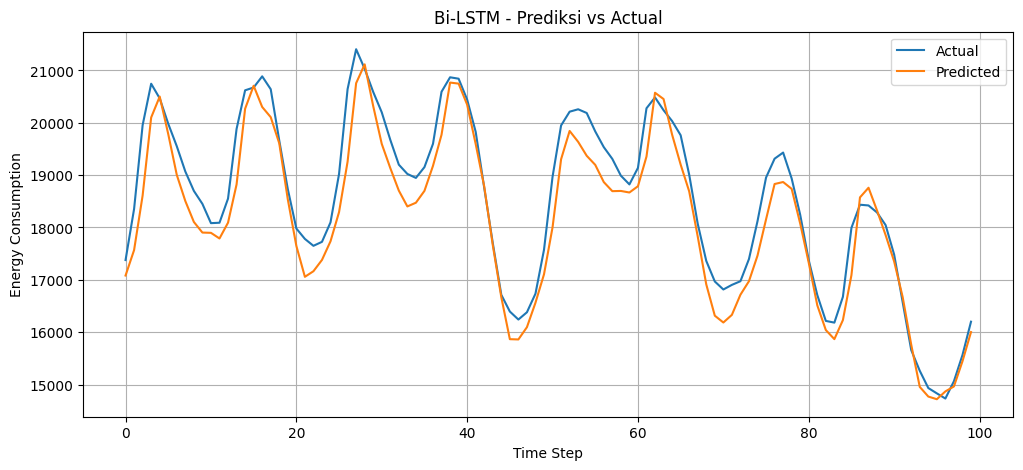

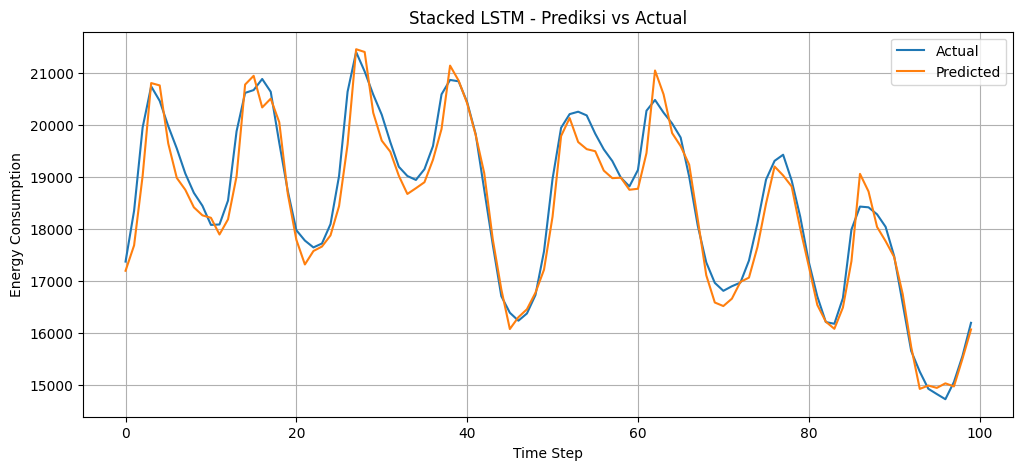


🎯 Kesimpulan Percobaan:
Model terbaik berdasarkan MAE adalah LSTM,
dengan nilai MAE = 283.25 dan RMSE = 389.25.
Berikut analisis singkat:
Model LSTM menunjukkan performa terbaik dalam memprediksi konsumsi energi.

💡 Saran Peningkatan:
- Lakukan tuning hyperparameter seperti jumlah unit LSTM atau learning rate.
- Tambahkan fitur tambahan seperti hari dalam seminggu atau musim.
- Coba model hybrid atau ensemble antara beberapa model.


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Fungsi evaluasi model
def evaluate_model(model, X_test, y_test, scaler, model_name):
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test)

    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)

    return {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'Predictions': y_pred_inv,
        'Actuals': y_test_inv
    }

# Evaluasi ketiga model
results = []

# Ganti dengan model yang sudah kamu latih sebelumnya
results.append(evaluate_model(model_lstm, X_test, y_test, scaler, "LSTM"))
results.append(evaluate_model(model_bilstm, X_test, y_test, scaler, "Bi-LSTM"))
results.append(evaluate_model(model_stacked, X_test, y_test, scaler, "Stacked LSTM"))

# Buat DataFrame untuk perbandingan
df_results = pd.DataFrame(results)
print("\n📊 Perbandingan Ketiga Model:")
print(df_results[['Model', 'MSE', 'RMSE', 'MAE']].to_string(index=False))

# Plot prediksi vs aktual untuk setiap model
def plot_prediction(result, index=0):
    actual = result['Actuals'][:100]
    predicted = result['Predictions'][:100]
    title = result['Model']

    plt.figure(figsize=(12, 5))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.title(f"{title} - Prediksi vs Actual")
    plt.xlabel('Time Step')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n📈 Visualisasi Prediksi vs Aktual:")
for res in results:
    plot_prediction(res)

# Kesimpulan otomatis
best_mae_row = df_results.loc[df_results['MAE'].idxmin()]
best_model = best_mae_row['Model']
best_mae = best_mae_row['MAE']
best_rmse = best_mae_row['RMSE']

print("\n🎯 Kesimpulan Percobaan:")
print(f"Model terbaik berdasarkan MAE adalah {best_model},")
print(f"dengan nilai MAE = {best_mae:.2f} dan RMSE = {best_rmse:.2f}.")
print("Berikut analisis singkat:")
if best_model == "LSTM":
    print("Model LSTM menunjukkan performa terbaik dalam memprediksi konsumsi energi.")
elif best_model == "Bi-LSTM":
    print("Bi-LSTM memberikan hasil yang lebih baik karena dapat melihat pola dari dua arah.")
else:
    print("Stacked LSTM tidak memberikan peningkatan signifikan dibandingkan model sederhana.")

print("\n💡 Saran Peningkatan:")
print("- Lakukan tuning hyperparameter seperti jumlah unit LSTM atau learning rate.")
print("- Tambahkan fitur tambahan seperti hari dalam seminggu atau musim.")
print("- Coba model hybrid atau ensemble antara beberapa model.")

In [45]:
df_results.to_csv('hasil_evaluasi.csv', index=False)

In [46]:
pip install reportlab

In [47]:
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet

doc = SimpleDocTemplate("laporan_forecasting.pdf")
styles = getSampleStyleSheet()
story = []

story.append(Paragraph("Laporan Forecasting Konsumsi Energi", styles['Title']))
story.append(Spacer(1, 24))

story.append(Paragraph("Hasil Evaluasi", styles['Heading2']))
story.append(Paragraph(f"LSTM - MSE: 151513.29, RMSE: 389.25, MAE: 283.25", styles['Normal']))
story.append(Paragraph(f"Bi-LSTM - MSE: 150979.91, RMSE: 388.56, MAE: 290.66", styles['Normal']))
story.append(Paragraph(f"Stacked LSTM - MSE: 162876.02, RMSE: 403.58, MAE: 314.81", styles['Normal']))

doc.build(story)
print("PDF laporan berhasil dibuat!")

PDF laporan berhasil dibuat!


In [50]:
def predict_next_hour(model, last_sequence, scaler):
    # Normalisasi
    last_seq_scaled = scaler.transform(last_sequence.reshape(-1, 1))

    # Reshape untuk input LSTM: [batch, timesteps, features]
    last_seq_reshaped = last_seq_scaled.reshape(1, -1, 1)

    # Prediksi
    prediction_scaled = model.predict(last_seq_reshaped, verbose=0)

    # Inverse transform ke skala asli
    prediction_actual = scaler.inverse_transform(prediction_scaled)[0][0]

    return prediction_actual

In [52]:
from copy import deepcopy

# Salin 24 jam terakhir sebagai awal prediksi
input_seq = df['energy_consumption'].values[-24:].tolist()

# Simpan hasil prediksi
predictions_lstm = []
predictions_bilstm = []
predictions_stacked = []

for _ in range(24):  # Prediksi 24 jam ke depan
    # Prediksi 1 jam berikutnya
    pred_lstm = predict_next_hour(model_lstm, np.array(input_seq), scaler)
    pred_bilstm = predict_next_hour(model_bilstm, np.array(input_seq), scaler)
    pred_stacked = predict_next_hour(model_stacked, np.array(input_seq), scaler)

    # Tambahkan ke list hasil
    predictions_lstm.append(pred_lstm)
    predictions_bilstm.append(pred_bilstm)
    predictions_stacked.append(pred_stacked)

    # Geser window: hapus jam pertama, tambahkan prediksi sebagai jam baru
    input_seq.pop(0)
    input_seq.append(pred_lstm)  # Gunakan salah satu prediksi (misalnya dari LSTM) as input berikutnya

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

In [53]:
import pandas as pd

# Buat DataFrame hasil prediksi
df_predictions = pd.DataFrame({
    'LSTM': predictions_lstm,
    'Bi-LSTM': predictions_bilstm,
    'Stacked LSTM': predictions_stacked
})

print("Prediksi Konsumsi Energi 24 Jam ke Depan:")
print(df_predictions.to_string(index=False))

Prediksi Konsumsi Energi 24 Jam ke Depan:
        LSTM      Bi-LSTM  Stacked LSTM
14140.718750 13932.730469  14082.118164
13776.893555 13566.905273  13649.655273
13478.712891 13294.588867  13335.945312
13287.564453 13126.321289  13131.556641
13205.600586 13078.904297  13051.662109
13238.965820 13134.541016  13073.747070
13360.345703 13271.546875  13196.080078
13534.305664 13435.651367  13371.158203
13721.189453 13587.809570  13545.484375
13884.768555 13689.909180  13701.693359
13995.207031 13736.652344  13789.537109
14051.124023 13750.282227  13815.052734
14070.879883 13744.181641  13810.719727
14083.166992 13761.472656  13818.628906
14114.205078 13822.894531  13871.343750
14177.165039 13935.233398  13965.869141
14282.100586 14087.269531  14109.514648
14418.014648 14268.673828  14273.466797
14537.885742 14398.120117  14415.050781
14611.864258 14460.303711  14495.407227
14620.105469 14452.229492  14503.320312
14549.429688 14369.500977  14433.310547
14401.018555 14228.692383  14287.96972

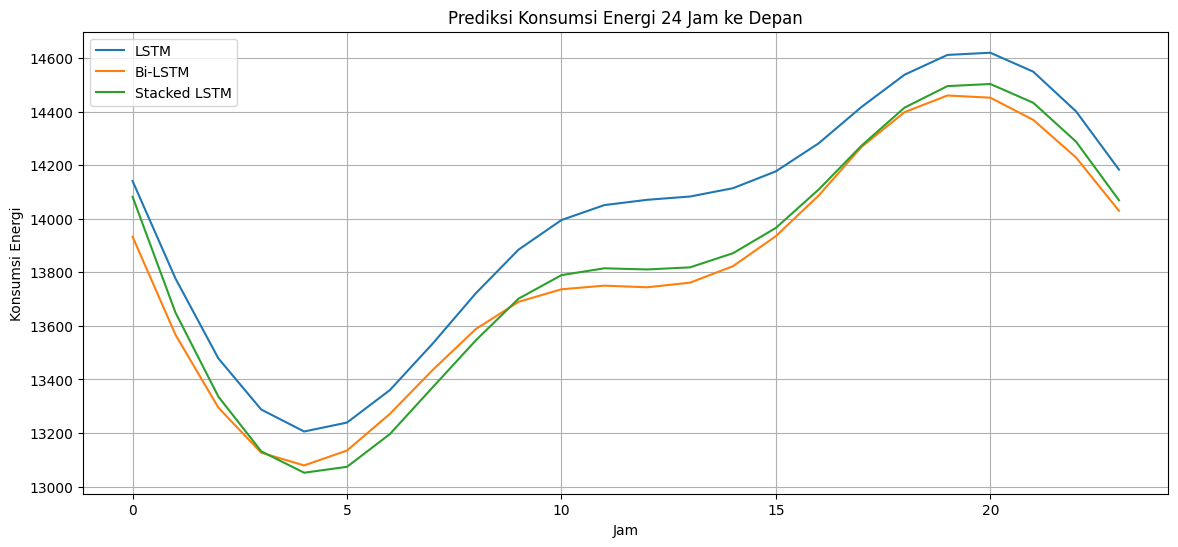

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(predictions_lstm, label='LSTM')
plt.plot(predictions_bilstm, label='Bi-LSTM')
plt.plot(predictions_stacked, label='Stacked LSTM')
plt.title('Prediksi Konsumsi Energi 24 Jam ke Depan')
plt.xlabel('Jam')
plt.ylabel('Konsumsi Energi')
plt.legend()
plt.grid(True)
plt.show()